# Creation of mock images with analytical distribution and fit of those images and retrieve associated H0 
by Lyne Van de Vyvere lyne.vandevyvere@uliege.be

lenstronomy version 1.6.0

### imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.fits as pf
import lenstronomy

from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.pixel_grid import PixelGrid
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Analysis.td_cosmography import TDCosmography
from lenstronomy.Util import util
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

import module_noise_mask as nm

from lenstronomy.Workflow.fitting_sequence import FittingSequence
import lenstronomy.Plots.lens_plot as lens_plot
import lenstronomy.Plots.chain_plot as chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from astropy.nddata import Cutout2D
from lenstronomy.Cosmo.cosmo_solver import ddt2h0

import ast
import copy  

## Mock creation

### useful functions

In [2]:
#functions to find the element of an array that is the closest to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return np.array([array[idx]])
def find_nearest_arg(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### mock creation code
the idea is the following : define the characteritics of the mocks ; define the lens models etc usefull in the code ; make a loop to create all wanted mocks.

In [3]:

path_out = os.getcwd()
name_out = path_out + '/sie_multipole_highsnr_a4001_boxy_'
#place to save your created mocks

size=1 #the size of the sample, you can have size = 3 and define angle, theta_E, q etc of each set of lens
source_pos_list = ['cusp_s','cusp_l','fold','cross'] #'cusp_l','cusp_s','fold','cross','middle_cusp' or a list [x_pos,y_pos]
contrast=1.6 #contrast between host and quasar flux in the source plane
n_pix=131 #output image number of pixels
delta_pix=0.08 #output image pixel size
z_lens = 0.271
z_source = 2.0
H0=70
Om0=0.3
cosmo =  FlatLambdaCDM(H0=H0, Om0=Om0)
R_sersic=0.1 #source size
angle = np.array([22.*np.pi/180.]) #position angle of the SIE, the size of the array should be the same as the size parameter
theta_E_lenstro = np.array([2.]) #Einstein radius of the SIE
q = np.array([0.8]) #axis ratio of the SIE
a_4 = np.array([0.01]) #multipole strength
phi_4 = np.array([45.*np.pi/180.])+ angle #position angle of the multipole : 0 is discy; 45 is boxy (with respect to the SIE main axis)
e1 = (1.-q)/(1.+q)*np.cos(2*angle) #transform SIE parameters into lenstronomy conventions
e2 = (1.-q)/(1.+q)*np.sin(2*angle) #transform SIE parameters into lenstronomy conventions
shear_strengh = 0.05
shear_angle = 30.*np.pi/180. #with respect to the SIE main axis (the "angle" of the SIE will be added later in the code)

#choose PSF to use
PSF_TDLMC = True
path_psf = os.getcwd()

#specifications for the noise 
#those values are typical of WFPC3 camera with F160W filter
mag_zeropoint = 25.96
back_mag = 22.3 #mag/arcsec**2
exp_time = 5400.
exp_num = 1
ron = 21. #https://hst-docs.stsci.edu/hsp/past-hst-proposal-opportunities/the-hubble-space-telescope-primer-for-cycle-27/hst-cycle-27-primer-scientific-instrument-comparisons
res_in_arcsec=delta_pix

#specifications for the mask to be above a noise threshold
threshold=2.
num_real=150
seed=1235

#Definitions of les models, psf, image model etc
lens_model_list=['SIE','MULTIPOLE','SHEAR_GAMMA_PSI']
Lens=LensModel(lens_model_list)
LensModExt = LensModelExtensions(Lens)
source_model_list=['SERSIC']
Source = LightModel(source_model_list)
point_source_model_list=['LENSED_POSITION']
lensEquationSolver = LensEquationSolver(Lens)
PS = PointSource(point_source_model_list,fixed_magnification_list=[False]) 
kwargs_psf={'psf_type':'GAUSSIAN','fwhm':0.15,'truncation':11,'pixel_size':delta_pix}
if PSF_TDLMC is True: #if specific PSF : re-write the kwargs_psf
    psf_tdlmc = pf.open(path_psf+'/psf_TDLMC.fits')
    psf_tdlmc_data = psf_tdlmc[0].data
    psf_tdlmc_data[psf_tdlmc_data <=10**-10]=10**-10
    psf_tdlmc_data/=np.sum(psf_tdlmc_data)
    kwargs_psf = {'psf_type':'PIXEL','kernel_point_source':psf_tdlmc_data.copy(),'kernel_point_source_init':psf_tdlmc_data.copy()}
    
psf = PSF(**kwargs_psf)
kwargs_pixel_grid = {'nx':n_pix,'ny':n_pix,'transform_pix2angle':np.array([[1, 0],[0, 1]])*delta_pix,'ra_at_xy_0':-n_pix/2.*delta_pix,'dec_at_xy_0':-n_pix/2.*delta_pix}
Grid = PixelGrid(**kwargs_pixel_grid)
image_class = ImageModel(Grid,psf,Lens,Source,point_source_class=PS)
kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': [],
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_model_list
                 }
lensProp = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

<ipython-input-4-7be7f0db2e81>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal','datalim')


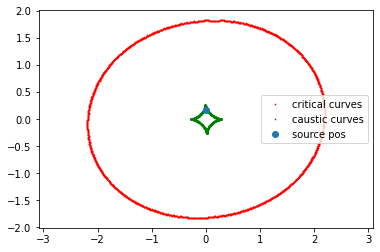

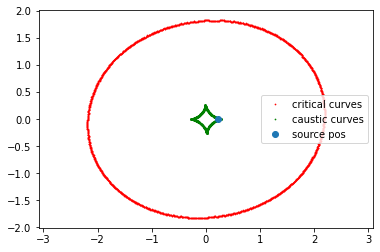

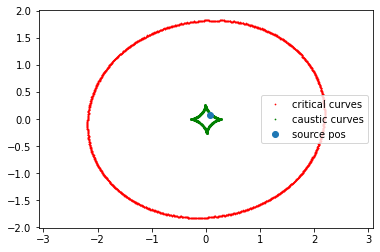

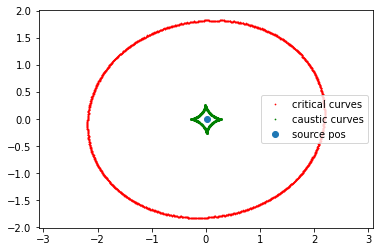

In [4]:
#let's start the loop that goes into each set of mock (given angle, theta_E, a4 etc)
for i in range(size):

    kwargs_lens = [{'theta_E':theta_E_lenstro[i],'e1':e1[i],'e2':e2[i],'center_x':0,'center_y':0},
                   {'m':4,'a_m':a_4[i],'phi_m':phi_4[i],'center_x':0,'center_y':0},
                   {'gamma_ext':shear_strengh, 'psi_ext':shear_angle+angle[i], 'ra_0':0., 'dec_0':0.}]
    #for each set of mock, we do a bunch of configurations with the same underlying mass model
    for source_pos in source_pos_list :
        numImages = 4
        #the source position can either be entered as an array (if ...) or as keywords to have predefined configurations (else ...)
        if type(source_pos) is list :
            pos_x = source_pos[0]
            pos_y = source_pos[1]
            name_end = '_custom'
        else :
            #due to new version of lenstronomy (v1.6.0), the following lines of code had to be updated to this : 
            
            #the basic idea is to have the inner caustic  and draw the point_source 
            #at a specific location compared to the caustic cusp
            
            ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = LensModExt.critical_curve_caustics(kwargs_lens)
            ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = np.asarray(ra_crit_list), np.asarray(dec_crit_list), np.asarray(ra_caustic_list), np.asarray(dec_caustic_list)
            #note that the retrieved list are in fact list of a lot of smaller lists 
            #(the [0] is 99% of the time the inner cautic and the others are small portions of the external caustic).
            #To plot the critical curves and caustics, we want to plot all small pieces in 1 -> ravelling
            ra_crit_list_rav, dec_crit_list_rav, ra_caustic_list_rav, dec_caustic_list_rav = np.concatenate(ra_crit_list), np.concatenate(dec_crit_list), np.concatenate(ra_caustic_list), np.concatenate(dec_caustic_list)
            
            plt.scatter(ra_crit_list_rav,dec_crit_list_rav,s=0.5,c='r',label="critical curves")
            plt.scatter(ra_caustic_list_rav,dec_caustic_list_rav,s=0.5,c='g',label="caustic curves")
            
            #as I said, the inner caustic is the element [0] of the list.
            #We want to find extremal points in the caustic to pin point the longest cusp position
            
            #first, we try the max in the y direction
            ra_max_dec,dec_max_dec=ra_caustic_list[0][dec_caustic_list[0]==np.max(dec_caustic_list[0])],dec_caustic_list[0][dec_caustic_list[0]== np.max(dec_caustic_list[0])]
            if len(ra_max_dec)>1 : #it may happen that 2 points are retrieved becaus eof the symmetry -> we only need 1
                ra_max_dec=ra_max_dec[0]
                dec_max_dec=dec_max_dec[0]
            #convert the cusp point into angle and radius
            angle_max_dec = np.arctan2(dec_max_dec,ra_max_dec)
            r_max_dec = np.sqrt(ra_max_dec**2+dec_max_dec**2)
            
            #second, we do the same in the x direction
            ra_max_ra,dec_max_ra=ra_caustic_list[0][ra_caustic_list[0]==np.max(ra_caustic_list[0])],dec_caustic_list[0][ra_caustic_list[0]== np.max(ra_caustic_list[0])]
            if len(ra_max_ra)>1 :
                ra_max_ra=ra_max_ra[0]
                dec_max_ra=dec_max_ra[0]
            angle_max_ra = np.arctan2(dec_max_ra,ra_max_ra)
            r_max_ra = np.sqrt(ra_max_ra**2+dec_max_ra**2)
            
            #and finally, we take the cusp that is the longest (the further away from the center)
            if r_max_dec>r_max_ra :
                angle_compa = angle_max_dec
            else :
                angle_compa = angle_max_ra
            
            #we define the angle of every point of the inner caustic
            phi_caustic = np.arctan2(dec_caustic_list[0],ra_caustic_list[0]).ravel()
            
            if source_pos == 'cusp_l': 
                #cusp along major axis
                pos_x = 0.8*ra_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa)]
                pos_y = 0.8*dec_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa)]
                #the 0.8 is aritrary, we did not want to have a source exactly on the cusp.
                name_end = '_cusp_l'
            elif source_pos == 'cusp_s':
                #cusp along minor axis
                pos_x = 0.8*ra_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa+np.pi/2.)]
                pos_y = 0.8*dec_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa+np.pi/2.)]
                name_end = '_cusp_s'
            elif source_pos == 'cross':
                #cross
                pos_x = 0.05*ra_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa)]
                pos_y = 0.05*dec_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa)]
                name_end = '_cross'
            elif source_pos == 'fold':
                #fold
                pos_x = 0.8*ra_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa+np.pi/4)]
                pos_y = 0.8*dec_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa+np.pi/4)]
                name_end = '_fold'
            elif source_pos == 'middle_cusp_l' :
                pos_x = 0.6*ra_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa)]
                pos_y = 0.6*dec_caustic_list[0][find_nearest_arg(phi_caustic,angle_compa)]
                name_end = '_middle_cusp_l'
                
            elif source_pos =='double':
                print('not yet implemented')
                numImages=2
                continue
            else :
                print('check source_pos_list !')
                continue

            #plot of the source position on the caustic/crit plot started earlier
            plt.scatter(pos_x,pos_y,label="source pos")
            plt.legend()
            plt.axes().set_aspect('equal','datalim')
            plt.show()

        #find the PS positions in the image plane
        x_image, y_image = lensEquationSolver.findBrightImage(pos_x, pos_y, kwargs_lens, numImages=numImages,
                                                      min_distance=delta_pix, search_window=n_pix * delta_pix,
                                                      num_iter_max=100,arrival_time_sort=True) 
        #the 5.07*(0.1/R_sersic) factor comes from the link between the 'amp' param and the actual integrated flux of the source 
        #in the source plane. We used it to have only the 'contrast' param that differentiate the source and PS effective fluxes.
        kwargs_source=[{'amp':100.*contrast*5.07*(0.1/R_sersic)**2,'R_sersic':R_sersic,'n_sersic':3.,'center_x':pos_x,'center_y':pos_y}]


        mag = Lens.magnification(x_image, y_image, kwargs=kwargs_lens)
        kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                            'point_amp': np.abs(mag)*100}]
        
        #create the image
        im = image_class.image(kwargs_lens = kwargs_lens, kwargs_source = kwargs_source,kwargs_ps=kwargs_ps)
        
        pmap = util.image2array(im)
        
        #use the module "noise_module" to create noise and mask based on the noise
        #this way of adding noise is based on the seagle code in ?C++? doing the exact same thing
        noise_add,noise_gen = nm.noise_creation(pmap,mag_zeropoint,back_mag,exp_time,exp_num,ron,res_in_arcsec,
                                        fix_seed=True,seed=seed)

        mask = nm.make_mask(pmap,mag_zeropoint,back_mag,exp_time,exp_num,ron,res_in_arcsec,threshold=threshold,
                    number_realisation=num_real,fix_seed=True,seed=seed)
        image = im + util.array2image(noise_add)
        noise_map=util.array2image(noise_gen)
        mask_map=util.array2image(mask)
        
        #calculate the time delay
        t_days = lensProp.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
        dt_days =  t_days[1:] - t_days[0]
        
        #export the images
        hdu = pf.PrimaryHDU(im)
        for w in [kwargs_source,kwargs_ps,kwargs_psf,kwargs_pixel_grid]: 
            #to save a dic/list as string with numpy array inside -> need to transform the array into a list 
            #(otherwise, it will save "array([..])" which is not easy to read with ast.literal_eval())
            if type(w)==type([]):
                for x in w :
                    for k,v in x.items():
                        if type(v)==type(np.array([])):
                            x[k]=v.tolist()
            elif type(w)==type({}):
                for k,v in w.items():
                    if type(v)==type(np.array([])):
                        w[k]=v.tolist()

        hdu.header['DELTAPIX']=delta_pix,'pixel size in arcsec'
        hdu.header['NAME']="SIE+multipole",'name'
        hdu.header['IM1_RA']=kwargs_ps[0]['ra_image'][0],'quasar image1 RA position in arsec'
        hdu.header['IM1_DEC']=kwargs_ps[0]['dec_image'][0],'quasar image1 DEC position in arsec'
        hdu.header['IM2_RA']=kwargs_ps[0]['ra_image'][1],'quasar image2 RA position in arsec'
        hdu.header['IM2_DEC']=kwargs_ps[0]['dec_image'][1],'quasar image2 DEC position in arsec'
        hdu.header['IM3_RA']=kwargs_ps[0]['ra_image'][2],'quasar image3 RA position in arsec'
        hdu.header['IM3_DEC']=kwargs_ps[0]['dec_image'][2],'quasar image3 DEC position in arsec'
        hdu.header['IM4_RA']=kwargs_ps[0]['ra_image'][3],'quasar image4 RA position in arsec'
        hdu.header['IM4_DEC']=kwargs_ps[0]['dec_image'][3],'quasar image4 DEC position in arsec'
        hdu.header['DELAY1']=t_days[0],'delay in days at image1 position'
        hdu.header['DELAY2']=t_days[1],'delay in days at image2 position'
        hdu.header['DELAY3']=t_days[2],'delay in days at image3 position'
        hdu.header['DELAY4']=t_days[3],'delay in days at image4 position'
        hdu.header['KWSOURCE']=str(kwargs_source)
        hdu.header['KWPS']=str(kwargs_ps)
        hdu.header['KWGRID']=str(kwargs_pixel_grid)
        hdu.header['KWLENS']=str(kwargs_lens)
        hdu.header['ANGLE']=angle[i]
        hdu.header['THETAE']=theta_E_lenstro[i]
        if PSF_TDLMC is True :
            hdu.header['KWPSF']= path_psf + '/PSF_TDLMC.fits'
        else :
            hdu.header['KWPSF']=str(kwargs_psf)
        hdu2=pf.ImageHDU(data=image,name='noised_image')
        #hdu2.header=hdu.header
        
        hdu3=pf.ImageHDU(data=noise_map,name='noise_map')
        hdu3.header['MAGZERO']=mag_zeropoint,'magnitude of zero point of the telescope'
        hdu3.header['BACKMAG']=back_mag,'magnitude of the background'
        hdu3.header['EXPTIME']=exp_time,'exposure time used to create the noise'
        hdu3.header['EXPNUM']=exp_num,'number of exposure used to create the noise'
        hdu3.header['RON']=ron,'read out noise considered to create the noise'
        hdu3.header['DELTAPIX']=res_in_arcsec,'pixel size'
        hdu4=pf.ImageHDU(data=mask_map,name='mask')
        hdu4.header['TRESH']=threshold,'thresold used to create the mask'
        hdu4.header['NUMREAL']=num_real,'number of realisation used to create the mask'
        
        HDU_list = pf.HDUList([hdu,hdu2,hdu3,hdu4])
        
        name = name_out + str(i) + name_end + '.fits'
        HDU_list.writeto(name,overwrite=True)

    
    

## Fit the mocks

!!!!!!!!!!!!!!!!!
sie_multipole_highsnr_a4001_boxy_0_cusp_l.fits
!!!!!!!!!!!!!!!!!
lens model :  ['SIE', 'SHEAR']
source model :  ['SERSIC']
ps_param  [[{'ra_image': array([ 1.79083873,  1.80948634,  2.1408179 , -1.6979555 ]), 'dec_image': array([-1.10511806,  1.25222105,  0.11059296, -0.07773326]), 'point_amp': array([2524.97533274, 2573.40644724, 4606.32628329,  347.77756201])}], [{'ra_image': array([0.1, 0.1, 0.1, 0.1]), 'dec_image': array([0.1, 0.1, 0.1, 0.1]), 'point_amp': array([0.1, 0.1, 0.1, 0.1])}], [{}], [{'ra_image': array([-10., -10., -10., -10.]), 'dec_image': array([-10., -10., -10., -10.]), 'point_amp': array([0., 0., 0., 0.])}], [{'ra_image': array([10., 10., 10., 10.]), 'dec_image': array([10., 10., 10., 10.]), 'point_amp': array([100000., 100000., 100000., 100000.])}]]
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
4

/home/lyne/lenstronomy_linked_github/lenstronomy/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/lyne/lenstronomy_linked_github/lenstronomy/lenstronomy/Plots/model_band_plot.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/lyne/lenstronomy_linked_github/lenstronomy/lenstronomy/Plots/model_band_plot.py:58: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')
/home/lyne

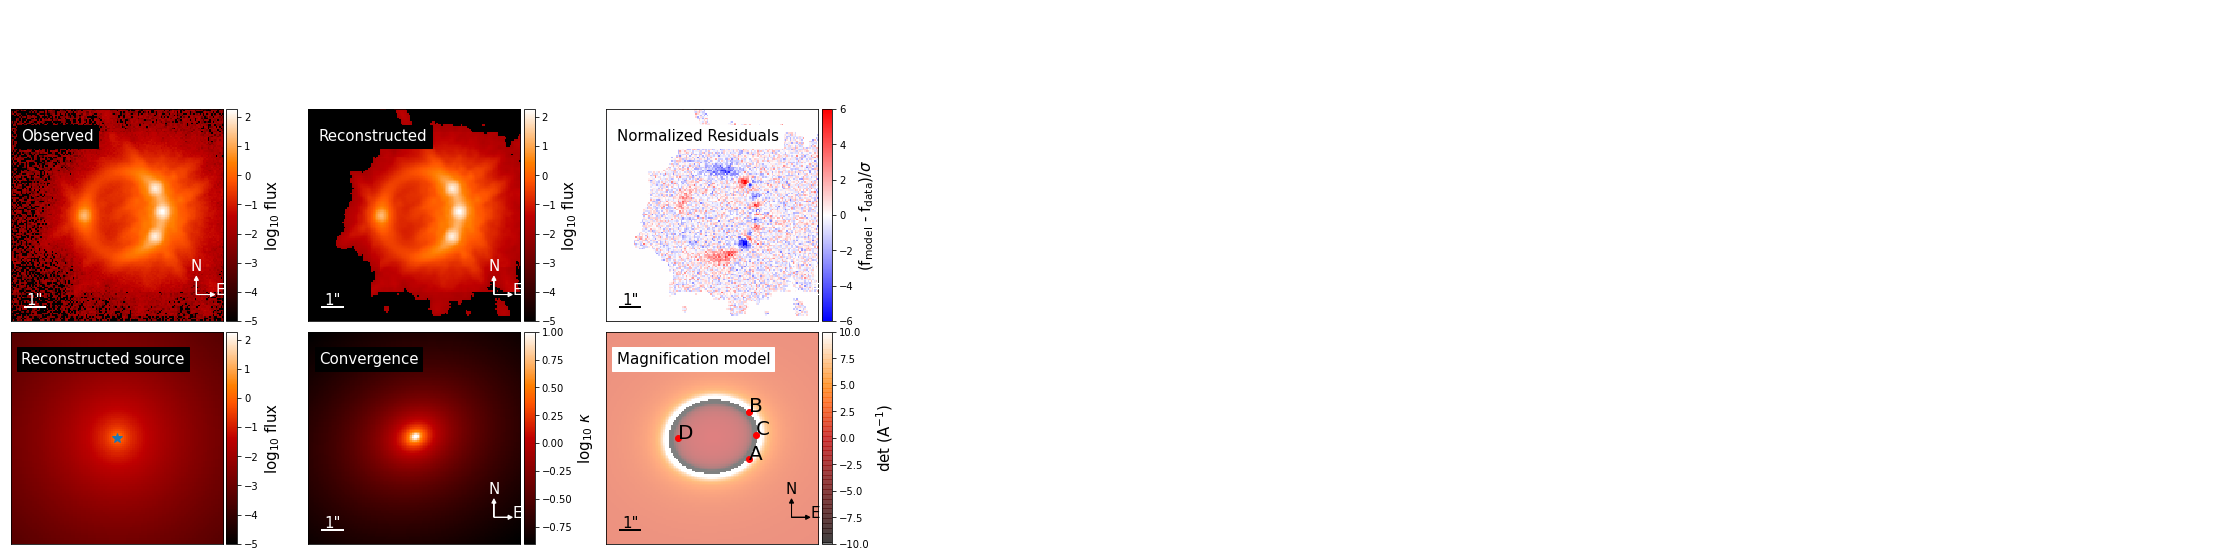

/home/lyne/lenstronomy_linked_github/lenstronomy/lenstronomy/Plots/model_band_plot.py:496: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


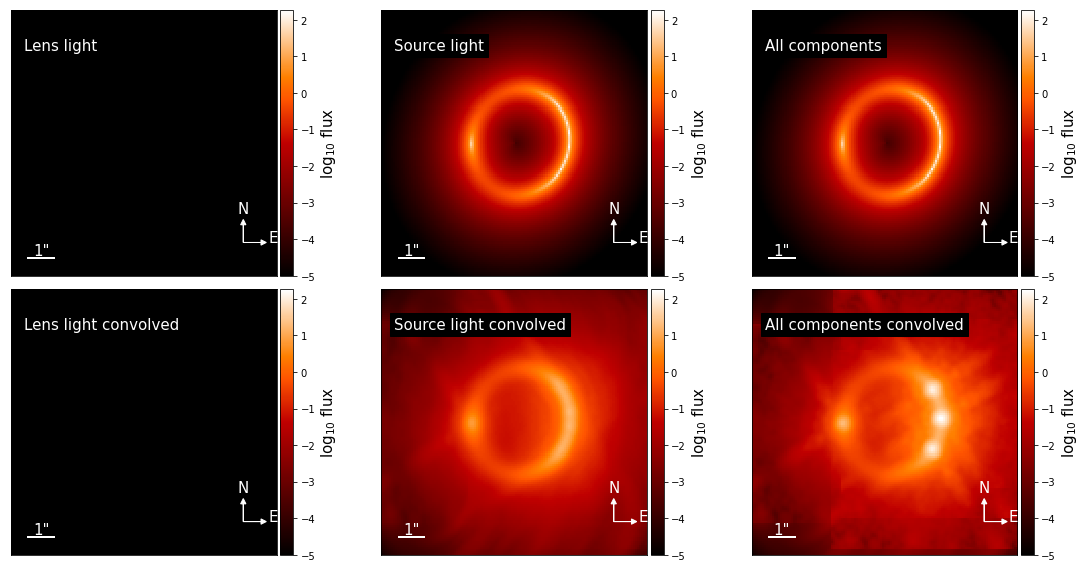

[0.22212964 0.2258213  0.22420764 0.22406077] [-0.00702079 -0.00688411 -0.00539033 -0.0056013 ]


<Figure size 432x288 with 0 Axes>

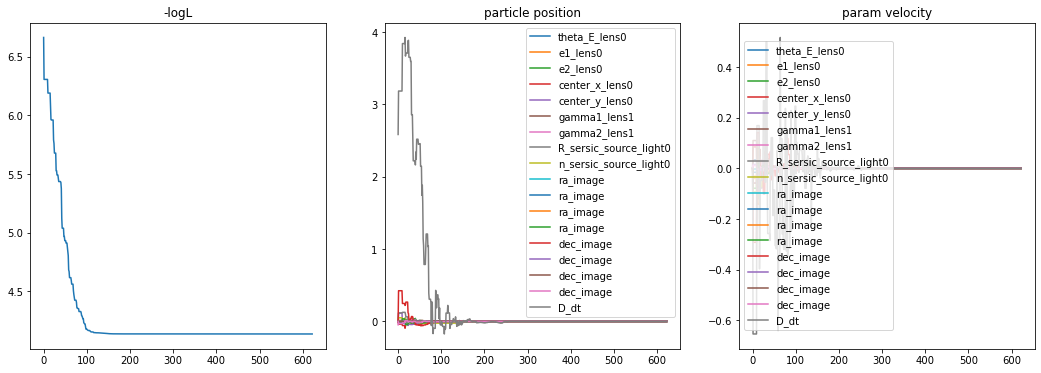

<Figure size 432x288 with 0 Axes>

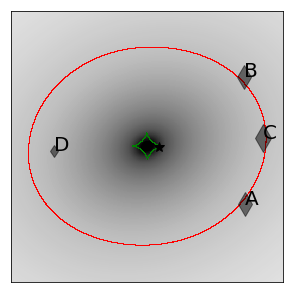

{'kwargs_lens': [{'theta_E': 1.9993807950337534, 'e1': 0.07756580678530205, 'e2': 0.07649116385113561, 'center_x': 0.0025143133525872387, 'center_y': -0.0037679856255679886}, {'gamma1': -0.012871621018861336, 'gamma2': 0.049568224160083364, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 836.3360812991579, 'R_sersic': 0.09820026980015696, 'n_sersic': 2.998132859577945, 'center_x': 0.22405483613673188, 'center_y': -0.006224133820340094}], 'kwargs_lens_light': [], 'kwargs_ps': [{'ra_image': array([ 1.78998146,  1.81030199,  2.14087226, -1.69771845]), 'dec_image': array([-1.10586395,  1.25127373,  0.10971724, -0.07789378]), 'point_amp': array([2545.61055814, 2568.71130659, 4602.87046909,  346.84069602])}], 'kwargs_special': {'D_dt': 1394.275901126959}, 'kwargs_extinction': []}


/home/lyne/miniconda3/envs/lenstro_linked_github/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
#Need to have it =1 (in the code it is then saying that you have an extended source centered on the point source)
source_save = 1 

#I want to do the same modeling on several images
#I thus have to create a "image_file_name_list"
image_base_name = 'sie_multipole_highsnr_a4001_boxy_'
size=1
source_pos_list = ['_cusp_l']
image_file_name_list = []
for i in range(size):
    for source_config in source_pos_list:
        image_file_name_list.append(image_base_name+str(i)+source_config+'.fits')
#another possibility is to enter by hand all the image names:
#image_file_name_list=['sie_multipole_test0.fits','sie_multipole_test1.fits','sie_multipole_test2.fits',
#                     'sie_multipole_test3.fits','sie_multipole_test4.fits','sie_multipole_test5.fits',
#                     'sie_multipole_test6.fits','sie_multipole_test7.fits','sie_multipole_test8.fits',
#                     'sie_multipole_test9.fits','sie_multipole_test10.fits','sie_multipole_test11.fits',
#                     'sie_multipole_test12.fits','sie_multipole_test13.fits','sie_multipole_test14.fits']

        
#the path where to find the images        
file_path = os.getcwd()+'/'


#a few options I added to ease the coding
use_fix_source=False #if true, fix the source size and n_sersic in the fitting
use_init_source=True #if true, use the source size and n_sersic input (in the header) as initial condition in the fitting
use_fix_ps=False #idem for the point source positions
use_init_ps=True
use_sie_init = True #if true, it uses the sie input (just the sie componenent) as initial condition of the sie in the fitting
use_fix_shear = False
use_shear_init = False
use_Ddt = True #if true, will fit Ddt, useful to get easily the recovered H0
use_flux_ratios=False #if true, fit the flux ratios
no_mask = False #if false, makes a small mask in the center of the image, to cover a possible 5th image (not use here)
noise_image = True #if true, uses the noised image, else it uses the image without noise 
noise_mask = True #if true, will use the mask made with a threshold in the mocking process in the fitting (the likelihood will only use the points inside the mask)
#noise_mask is prepoderant on no_mask
TDLMC_psf = True
path_psf = os.getcwd()

#you can say you don't want to save the results if the chi2 is too bad
#I recommand to keep a huge number and not use it
chi_lim=1000000.


#the ending of the result files
name_out_files_ending = '_test_fit_SIE_shear'


#the model you want to fit
#you can add  " 'joint_lens_with_lens':[[0,1,['center_x','center_y']]] " for instance if you want the center of the lens model 0 and 1 to correspond
#you can also define several models to fit different models on every image: model_list=[{model 1 },{model 2}]
model_list=[{'lens_model_list':['SIE','SHEAR'],'source_model_list':['SERSIC'],'lens_light_model_list':[],
             'point_source_model_list': ['LENSED_POSITION']
             }
           
           ]

#the lenstronomy fitting kwargs list, you can have PSO, MCMC, psf_iteration, update_settings , ...    
fitting_kwargs_list = [
                       ['PSO',{'sigma_scale': 1., 'n_particles': 500, 'n_iterations': 1000}]]          

#################
#all the fine tuning was above
#now, the code begins
#################

#have to initialize np arrays
time_delay=np.zeros(4)
relative_delay=np.zeros(3)
relative_delay_sigma=np.zeros(3)
relative_flux=np.zeros(3)
relative_flux_sigma=np.zeros(3)

for num_image,image_file_name in enumerate(image_file_name_list) : #we will do the modeling on every image
    
    #1. load the image and header
    image_data, header_data = pf.getdata(file_path+image_file_name,header=True)
    print("!!!!!!!!!!!!!!!!!")
    print(image_file_name)
    print("!!!!!!!!!!!!!!!!!")
    if TDLMC_psf is True :
        psf_tdlmc = pf.open(path_psf+'/psf_TDLMC.fits')
        psf_tdlmc_data = psf_tdlmc[0].data
        psf_tdlmc_data[psf_tdlmc_data <=10**-10]=10**-10
        psf_tdlmc_data/=np.sum(psf_tdlmc_data)
        kwargs_psf = {'psf_type':'PIXEL','kernel_point_source':psf_tdlmc_data.copy(),'kernel_point_source_init':psf_tdlmc_data.copy()}

    else :
        kwargs_psf = ast.literal_eval(header_data['KWPSF'])
        
    deltaPix = header_data['DELTAPIX']
    numPix = header_data['NAXIS1']
    kwargs_data = {'ra_at_xy_0': ast.literal_eval(header_data['KWGRID'])['ra_at_xy_0'],
     'dec_at_xy_0': ast.literal_eval(header_data['KWGRID'])['dec_at_xy_0'],
     'transform_pix2angle': np.array(ast.literal_eval(header_data['KWGRID'])['transform_pix2angle'])}
    
    time_delay[0]=header_data['DELAY1']
    time_delay[1]=header_data['DELAY2']
    time_delay[2]=header_data['DELAY3']
    time_delay[3]=header_data['DELAY4']
    
    amplitude=ast.literal_eval(header_data['KWPS'])[0]['point_amp']
    for i in np.arange(3):
        relative_delay[i]=time_delay[i+1]-time_delay[0]
        relative_flux[i]=amplitude[i+1]/amplitude[0]
        relative_flux_sigma[i]=0.5
        if 2./100.*relative_delay[i]<1. : #the error in the delay is max(2% of the relative delay , 1 day)
            relative_delay_sigma[i]=1.
        else :
            relative_delay_sigma[i]=relative_delay[i]*2./100.
    
    if noise_image is True : #if noise is provided, use noise
        whole_file = pf.open(file_path+image_file_name)
        kwargs_data['image_data'] = whole_file[1].data
        cut_background = Cutout2D(whole_file[1].data,(20,20),(40,40))
        background_rms=cut_background.data.std()
        kwargs_data['background_rms'] = background_rms
        kwargs_data['noise_map']=whole_file[2].data
        kwargs_data['noise_map'][kwargs_data['noise_map']<10**-10]=10**-10
    else : #else, create a "fake noise" to be able to calculate a chi2
        kwargs_data['image_data'] = image_data
        kwargs_data['background_rms'] = 0.
        kwargs_data['noise_map']=np.sqrt(image_data)/10.+kwargs_data['background_rms']
        kwargs_data['noise_map'][kwargs_data['noise_map']<10**-10]=10**-10
        
    #2. some lenstronomy definitions
    
    kwargs_likelihood = {'check_positive_flux' : True, #will check that the source is not negative
                         'source_position_likelihood':True, #will check the 4 point sources raytrace back on the same position in the source plane with a precision given in the next line
                         'image_position_uncertainty':0.01
                    }
    
    if noise_mask is True : #use the mask based on the noise level
        whole_file = pf.open(file_path+image_file_name)
        mask = whole_file[3].data
        kwargs_likelihood['image_likelihood_mask_list']=[mask]
    else :
        mask = np.oneslike(image_data)
        

        
    kwargs_numerics = {}    

    band_list = [kwargs_data, kwargs_psf, kwargs_numerics]
    multi_band_list = []
    multi_band_list.append(band_list)
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'single-band','time_delays_measured': relative_delay,
                    'time_delays_uncertainties': relative_delay_sigma,'flux_ratios':relative_flux,'flux_ratio_errors':relative_flux_sigma}

    chain_list=[]
    param_fit=[]
    kwargs_result=[]
    bon_modele=[]
        
        
    # 3. specification for each model
    for i in range(len(model_list)):
        lens_model_list=model_list[i]['lens_model_list']
        source_model_list=model_list[i]['source_model_list']
        lens_light_model_list=model_list[i]['lens_light_model_list']
        point_source_model_list=model_list[i]['point_source_model_list']
        if source_save ==0 : #no extended source
            kwargs_constraints = {'solver_type': 'NONE',
                              'num_point_source_list': [4]}
        else: #if there is an extended source, the source and PS are centered in the same place
            kwargs_constraints = {'solver_type': 'NONE','joint_source_with_point_source': [[0, 0]],
                              'num_point_source_list': [4]}
        print('lens model : ',lens_model_list)
        print('source model : ',source_model_list)
        kwargs_lens_init=[]
        kwargs_lens_sigma = []
        kwargs_lens_fixed = []
        kwargs_lens_lower_limit = []
        kwargs_lens_upper_limit = []
        kwargs_source_init=[]
        kwargs_source_sigma = []
        kwargs_source_fixed =[]
        kwargs_source_lower_limit = []
        kwargs_source_upper_limit = []
        kwargs_lens_light_init=[]
        kwargs_lens_light_sigma = []
        kwargs_lens_light_fixed = []
        kwargs_lens_light_lower_limit = []
        kwargs_lens_light_upper_limit = []
        kwargs_ps_init=[]
        kwargs_ps_sigma = []
        kwargs_ps_fixed = []
        kwargs_ps_lower_limit = []
        kwargs_ps_upper_limit = []
        for lens in lens_model_list: #to avoid filling every time the kwargs init, sigma etc, I do it with general initialisation
            if lens=='SIE':
                kwargs_lens_init.append({'theta_E':1.5, 'e1':-0., 'e2':-0., 'center_x':0., 'center_y':0.})
                kwargs_lens_sigma.append({'theta_E':1.5,'e1':0.5,'e2':0.5,'center_x':0.5,'center_y' :0.5})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'theta_E': 0, 'e1': -1.5, 'e2': -1.5, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'theta_E': 100, 'e1': 1.5, 'e2': 1.5, 'center_x': 100, 'center_y': 100})
            elif lens=='NIE':
                kwargs_lens_init.append({'theta_E': 1.5, 'e1': 0., 'e2': 0., 's_scale': 0.1, 'center_x': 0, 'center_y': 0})
                kwargs_lens_sigma.append({'theta_E': 1., 'e1': 0.5, 'e2': 0.5, 's_scale': 1., 'center_x': 0.1, 'center_y': 0.1})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 's_scale': 0, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 's_scale': 100, 'center_x': 100, 'center_y': 100})
            elif lens=='PEMD':
                kwargs_lens_init.append({'theta_E':2., 'gamma':2., 'e1':0.0, 'e2':0.0, 'center_x':0.1, 'center_y':0.1})
                kwargs_lens_sigma.append({'theta_E':1.5, 'gamma':0.5, 'e1':0.5, 'e2':0.5, 'center_x':0.5, 'center_y':0.5})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'theta_E': 0, 'gamma': 0, 'e1': -1.5, 'e2': -1.5, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'theta_E': 100, 'gamma': 100, 'e1': 1.5, 'e2': 1.5, 'center_x': 100, 'center_y': 100})
            elif lens=='SPEMD_SMOOTH':
                #kwargs_lens_init.append({'theta_E':1.5, 'gamma':2., 'e1':0.0, 'e2':0.0, 'center_x':0., 'center_y':0.,'s_scale':0.05})
                kwargs_lens_init.append({'theta_E': 2.029508279395003, 'gamma': 2.4691818076814944, 'e1': 0.20864153273869696, 'e2': 0.22913279933097197, 'center_x': 0.11335945023129186, 'center_y': 0.006453304778595458,'s_scale':0.1})
                kwargs_lens_sigma.append({'theta_E':1.5, 'gamma':0.5, 'e1':0.5, 'e2':0.5, 'center_x':0.5, 'center_y':0.5,'s_scale':0.05})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'theta_E': 0, 'gamma': 0, 'e1': -1.5, 'e2': -1.5, 's_scale': 0, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'theta_E': 100, 'gamma': 100, 'e1': 1.5, 'e2': 1.5, 's_scale': 1.5, 'center_x': 100, 'center_y': 100})
                
            elif lens=='SPEP':
                kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2., 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.})
                kwargs_lens_sigma.append({'theta_E': 1.5, 'gamma': 1.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.5, 'center_y': 0.5})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'theta_E': 0, 'gamma': 0, 'e1': -1.5, 'e2': -1.5, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'theta_E': 100, 'gamma': 100, 'e1': 1.5, 'e2': 1.5, 'center_x': 100, 'center_y': 100})
            
            elif lens=='NFW':
                kwargs_lens_init.append({'Rs':0.5, 'alpha_Rs':1.1, 'center_x':0., 'center_y':0.})
                kwargs_lens_sigma.append({'Rs':1.5, 'alpha_Rs':1.5, 'center_x':0.5, 'center_y':0.5})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'Rs': 0, 'alpha_Rs': 0, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'Rs': 100, 'alpha_Rs': 10, 'center_x': 100, 'center_y': 100})
            elif lens=='NFW_ELLIPSE':
                kwargs_lens_init.append({'Rs':0.5, 'alpha_Rs':1.1, 'center_x':0., 'center_y':0.,'e1':0.1,'e2':0.1})
                kwargs_lens_sigma.append({'Rs':1.5, 'alpha_Rs':1.5, 'center_x':0.5, 'center_y':0.5,'e1':0.5,'e2':0.5})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'Rs': 0, 'alpha_Rs': 0, 'center_x': -100, 'center_y': -100,'e1':-1.5,'e2':-1.5})
                kwargs_lens_upper_limit.append({'Rs': 100, 'alpha_Rs': 10, 'center_x': 100, 'center_y': 100,'e1':1.5,'e2':1.5})
                
            elif lens=='SHEAR':
                kwargs_lens_init.append({'gamma1':0.0,'gamma2':-0.0,'ra_0':0.,'dec_0':0.})
                kwargs_lens_sigma.append({'gamma1':0.5,'gamma2':0.5,'ra_0':0.,'dec_0':0.})
                kwargs_lens_fixed.append({'ra_0':0.,'dec_0':0.})
                kwargs_lens_lower_limit.append({'gamma1': -0.5, 'gamma2': -0.5, 'ra_0': -100, 'dec_0': -100})
                kwargs_lens_upper_limit.append({'gamma1': 0.5, 'gamma2': 0.5, 'ra_0': 100, 'dec_0': 100})
            elif lens=='SHEAR_GAMMA_PSI':
                kwargs_lens_init.append({'gamma_ext': 0.05, 'psi_ext': 0., 'ra_0': 0, 'dec_0': -0})
                kwargs_lens_sigma.append({'gamma_ext': 0.1, 'psi_ext': np.pi, 'ra_0': 0, 'dec_0': -0})
                kwargs_lens_fixed.append({'ra_0': 0, 'dec_0': -0})
                kwargs_lens_lower_limit.append({'gamma_ext': 0, 'psi_ext': -np.pi, 'ra_0': -100, 'dec_0': -100})
                kwargs_lens_upper_limit.append({'gamma_ext': 1, 'psi_ext': np.pi, 'ra_0': 100, 'dec_0': 100})
            elif lens=='SIS':
                kwargs_lens_init.append({'theta_E':1.5, 'center_x':0., 'center_y':0.})
                kwargs_lens_sigma.append({'theta_E':1.5,'center_x':0.5,'center_y' :0.5})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'theta_E': 0, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'theta_E': 100, 'center_x': 100, 'center_y': 100})
            elif lens=='CHAMELEON':
                kwargs_lens_init.append({'alpha_1':1., 'w_c':2., 'w_t':2.5, 'e1':0.1, 'e2':0., 'center_x':0., 'center_y':0.})
                kwargs_lens_sigma.append({'alpha_1':5., 'w_c':5., 'w_t':5., 'e1':0.5, 'e2':0.5, 'center_x':0.2, 'center_y':0.2})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'alpha_1': 0, 'w_c': 0, 'w_t': 0, 'e1': -0.8, 'e2': -0.8, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'alpha_1': 100, 'w_c': 100, 'w_t': 100, 'e1': 0.8, 'e2': 0.8, 'center_x': 100, 'center_y': 100})
            elif lens=='DOUBLE_CHAMELEON':
                kwargs_lens_init.append({'alpha_1': 1., 'ratio': 0.5, 'w_c1': 2., 'w_t1': 2.5, 'e11': 0.1, 'e21': 0.1,
                           'w_c2': 0.06, 'w_t2': 0.67, 'e12': -0.1, 'e22': -0.1,
                           'center_x': 0., 'center_y': 0.})
                kwargs_lens_sigma.append({'alpha_1': 5., 'ratio': 5., 'w_c1': 5., 'w_t1': 5., 'e11': 0.5, 'e21': 0.5,
                           'w_c2': 5., 'w_t2': 5., 'e12': 0.5, 'e22': 0.5,
                           'center_x': 0.2, 'center_y': 0.2})
                kwargs_lens_fixed.append({})
                kwargs_lens_lower_limit.append({'alpha_1': 0, 'ratio': 0, 'w_c1': 0, 'w_t1': 0, 'e11': -0.8, 'e21': -0.8,
                           'w_c2': 0, 'w_t2': 0, 'e12': -0.8, 'e22': -0.8,
                           'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'alpha_1': 100, 'ratio': 100, 'w_c1': 100, 'w_t1': 100, 'e11': 0.8, 'e21': 0.8,
                           'w_c2': 100, 'w_t2': 100, 'e12': 0.8, 'e22': 0.8,
                           'center_x': 100, 'center_y': 100})
            elif lens=='MULTIPOLE':
                kwargs_lens_init.append({'m': 4,'a_m':0.05, 'phi_m':0., 'center_x': 0, 'center_y': 0})
                kwargs_lens_sigma.append({'m': 1,'a_m':0.05, 'phi_m':0.5, 'center_x': 0.5, 'center_y': 0.5})
                kwargs_lens_fixed.append({'m':4})
                kwargs_lens_lower_limit.append({'m': 2,'a_m':0, 'phi_m':-np.pi, 'center_x': -100, 'center_y': -100})
                kwargs_lens_upper_limit.append({'m': 100,'a_m':100, 'phi_m':np.pi, 'center_x': 100, 'center_y': 100})
                
            else:
                print(lens,' is not implemented') #if you want other models, just add a "elif"
            if 'joint_lens_with_lens' in model_list[i]: # if in the begining you specified you wanted linkes parameters (center or ellipticity or else)
                kwargs_constraints['joint_lens_with_lens']=model_list[i]['joint_lens_with_lens']
        
        for source in source_model_list: #do the same for the source
            if source=='SERSIC_ELLIPSE':
                kwargs_source_init.append({'amp':0.001, 'R_sersic':1.5, 'n_sersic':2.5, 'e1':-0., 'e2':0., 'center_x':0.1, 'center_y':0.1})
                kwargs_source_sigma.append({'amp':0.001, 'R_sersic':1.5, 'n_sersic':1.5, 'e1':0.5, 'e2':0.5, 'center_x':0.5, 'center_y':0.5})
                kwargs_source_fixed.append({})
                kwargs_source_lower_limit.append({'amp': 0, 'R_sersic': 0, 'n_sersic': 0.5, 'e1': -1.5, 'e2': -1.5,'center_x': -100, 'center_y': -100})
                kwargs_source_upper_limit.append({'amp': 100, 'R_sersic': 100, 'n_sersic': 8, 'e1': 1.5, 'e2': 1.5,'center_x': 100, 'center_y': 100})
            elif source=='SERSIC':
                kwargs_source_init.append({'amp':0.001, 'R_sersic':1.5, 'n_sersic':2.5, 'center_x':0., 'center_y':0.})
                kwargs_source_sigma.append({'amp':0.001, 'R_sersic':1.5, 'n_sersic':1.5, 'center_x':1.5, 'center_y':1.5})
                kwargs_source_fixed.append({})
                kwargs_source_lower_limit.append({'amp': 0, 'R_sersic': 0, 'n_sersic': 0.5, 'center_x': -100, 'center_y': -100})
                kwargs_source_upper_limit.append({'amp': 100, 'R_sersic': 100, 'n_sersic': 8,'center_x': 100, 'center_y': 100})          
            elif source=='SHAPELETS_POLAR':
                kwargs_source_init.append({'beta': 0.1, 'center_x': 0, 'center_y': 0})
                kwargs_source_sigma.append({'beta': 0.1, 'center_x': 0.1, 'center_y': 0.1})
                kwargs_source_fixed.append({'n_max':-1})
                kwargs_source_lower_limit.append({'beta': 0., 'center_x': -100, 'center_y': -100})
                kwargs_source_upper_limit.append({'beta': 10., 'center_x': 100, 'center_y': 100})
            else:
                print(source,' is not implemented')
            if 'joint_source_with_source' in model_list[i]:
                kwargs_constraints['joint_source_with_source']=model_list[i]['joint_source_with_source']
        for lens_light in lens_light_model_list :
            print(lens_light,' is not implemented')
        for ps in point_source_model_list : #same for point source
            if ps=='LENSED_POSITION' :
                kwargs_ps_init.append({'ra_image': np.array([-1.,-0.5,0.5,1.]), 'dec_image': np.array([-1., -0.5, 0.5, 1.]), 'point_amp': np.array([100., 100., 100., 100. ])})
                kwargs_ps_sigma.append({'ra_image':np.array([1.,1.,1.,1.]),'dec_image':np.array([1.,1.,1.,1.]),'point_amp':np.array([100.,100.,100.,100.])})
                kwargs_ps_fixed.append({})
                kwargs_ps_lower_limit.append({'ra_image':np.array([-10.,-10.,-10.,-10.]),'dec_image':np.array([-10.,-10.,-10.,-10.]),'point_amp':np.array([0.,0.,0.,0.])})
                kwargs_ps_upper_limit.append({'ra_image':np.array([10.,10.,10.,10.]),'dec_image':np.array([10.,10.,10.,10.]),'point_amp':np.array([100000.,100000.,100000.,100000.])})

            elif ps=='SOURCE_POSITION' :
                kwargs_ps_init.append({'ra_source': 0., 'dec_source': 0., 'point_amp': 100.})
                kwargs_ps_sigma.append({'ra_image':0.5,'dec_image':0.5,'point_amp':100.})
                kwargs_ps_fixed.append({})
                kwargs_ps_lower_limit.append({'ra_image':-10.,'dec_image':10.,'point_amp':0.})
                kwargs_ps_upper_limit.append({'ra_image':10.,'dec_image':10,'point_amp':100000.})

            else :
                print(ps,' is not implemented')
                
        #using the input values saved in the header if options were selected
        if use_fix_source is True :
            kwargs_source_fixed=ast.literal_eval(header_data['KWSOURCE'])
        if use_init_source is True :
            kwargs_source_init[0]=ast.literal_eval(header_data['KWSOURCE'])[0]
        if use_fix_ps is True : 
            kwargs_ps_fixed=ast.literal_eval(header_data['KWPS'])
            for w in kwargs_ps_fixed : #you can only have strings in header so you may have to transform back the arrays
                for k,v in w.items() :
                    if type(v)==type([]):
                        w[k]=np.array(v)
        if use_init_ps is True : 
            kwargs_ps_init=ast.literal_eval(header_data['KWPS'])
            for w in kwargs_ps_init :
                for k,v in w.items() :
                    if type(v)==type([]):
                        w[k]=np.array(v)
            kwargs_ps_sigma=copy.deepcopy(kwargs_ps_init)
            for w in kwargs_ps_sigma :
                for k,v in w.items() :
                    w[k]=v*0.+0.1
        if use_sie_init is True :
            kwargs_lens_init[0]=ast.literal_eval(header_data['KWLENS'])[0]
         
        if use_fix_shear is True :
            kwargs_lens_fixed[1]= ast.literal_eval(header_data['KWLENS'])[2]
        if use_shear_init is True :
            kwargs_lens_init[1]=ast.literal_eval(header_data['KWLENS'])[2]
            
        #ok, we can now create the kwargs params
        lens_params = [kwargs_lens_init,kwargs_lens_sigma,kwargs_lens_fixed,kwargs_lens_lower_limit,kwargs_lens_upper_limit]
        source_params = [kwargs_source_init,kwargs_source_sigma,kwargs_source_fixed,kwargs_source_lower_limit,kwargs_source_upper_limit]
        lens_light_params = [kwargs_lens_light_init,kwargs_lens_light_sigma,kwargs_lens_light_fixed,kwargs_lens_light_lower_limit,kwargs_lens_light_upper_limit]
        ps_params = [kwargs_ps_init,kwargs_ps_sigma,kwargs_ps_fixed,kwargs_ps_lower_limit,kwargs_ps_upper_limit]
        print('ps_param ',ps_params)
        kwargs_params = {'lens_model': lens_params,
                        'source_model': source_params,
                        'lens_light_model': lens_light_params,
                        'point_source_model': ps_params}
    
        kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list,
                       'lens_light_model_list': lens_light_model_list, 'point_source_model_list': point_source_model_list}
                       
        if use_Ddt is True : #fit Ddt ?
            
            kwargs_constraints['Ddt_sampling']= True
            kwargs_likelihood['time_delay_likelihood']= True
            kwargs_special_init = {'D_dt':5000}
            kwargs_special_sigma = {'D_dt':10000}
            kwargs_special_fixed = {}
            kwargs_special_lower_limit = {'D_dt':0}
            kwargs_special_upper_limit={'D_dt':10000}
            cosmo_param=[kwargs_special_init,kwargs_special_sigma,kwargs_special_fixed,kwargs_special_lower_limit,kwargs_special_upper_limit]
            kwargs_params['special']=cosmo_param
        if use_flux_ratios is True :
            kwargs_likelihood['flux_ratio_likelihood']=True

        #initialize the fitting sequence
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
    

        chain_list.append([])
        kwargs_result.append([])
        param_fit.append([])
        #4. do the modeling !! and save the results
        chain_list[i] = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result[i] = fitting_seq.best_fit()
        param_fit[i]=[kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params,fitting_kwargs_list]
        red_chi2=-chain_list[i][0][1][0][-1]/np.sum(mask)   #have the reduced chi2
        if red_chi2 <chi_lim : #if the chi2 is not too bad, let's do interesting stuff         
            
            #5. plot the results
            modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result[i], arrow_size=0.02, cmap_string="gist_heat",likelihood_mask_list=[mask])
             
    
            f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

            modelPlot.data_plot(ax=axes[0,0])
            modelPlot.model_plot(ax=axes[0,1])
            modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
            modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
            modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
            modelPlot.magnification_plot(ax=axes[1, 2])
            f.tight_layout()
            f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
            f.savefig(image_file_name[:-5]+'_res_mod_'+str(i)+name_out_files_ending+'.png')
            plt.show()

            f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

            modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
            modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
            modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
            modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
            modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
            modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
            f.tight_layout()
            f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
            f.savefig(image_file_name[:-5]+'_res_mod_suite_'+str(i)+name_out_files_ending+'.png')
            plt.show()

            f=plt.figure()
            for w in range(len(chain_list[i])): #look at likelihood evolution in the fitting
                f,axes_buf=chain_plot.plot_chain_list(chain_list[i], w)
                f.savefig(image_file_name[:-5]+'_res_chain_'+str(w)+'_'+str(i)+name_out_files_ending+'.png')
        
            mod=LensModel(lens_model_list)
            betara, betadec = mod.ray_shooting(kwargs_result[i]['kwargs_ps'][0]['ra_image'],kwargs_result[i]['kwargs_ps'][0]['dec_image'],kwargs_result[i]['kwargs_lens'])
            print(betara, betadec) #look at PS position ray traced back in the source plane to see if they match
            f, axex = plt.subplots(1, figsize=(5, 5), sharex=False, sharey=False) #look at caustics of the fit result
            lens_plot.lens_model_plot(axex, lensModel=LensModel(lens_model_list), kwargs_lens=kwargs_result[i]['kwargs_lens'],  
                             sourcePos_x=np.mean(betara), sourcePos_y=np.mean(betadec), point_source=True, with_caustics=True)
            plt.show()

            print(kwargs_result[i])
    res_all=[kwargs_result,chain_list,param_fit]    
    #6. SAVE THE RESULTS
    np.save(file_path+image_file_name[:-5]+'_model_sequence'+name_out_files_ending+'.npy',res_all)


## Run MCMC starting from the result of the previous PSO fit

----------------
sie_multipole_highsnr_a4001_boxy_0_cusp_l_model_sequence_test_fit_SIE_shear.npy
----------------


100%|██████████| 1550/1550 [17:43<00:00,  1.46it/s]


Computing the MCMC...
Number of walkers =  90
Burn-in iterations:  1500
Sampling iterations (in current run): 1550
1063.6349513530731 time taken for MCMC sampling


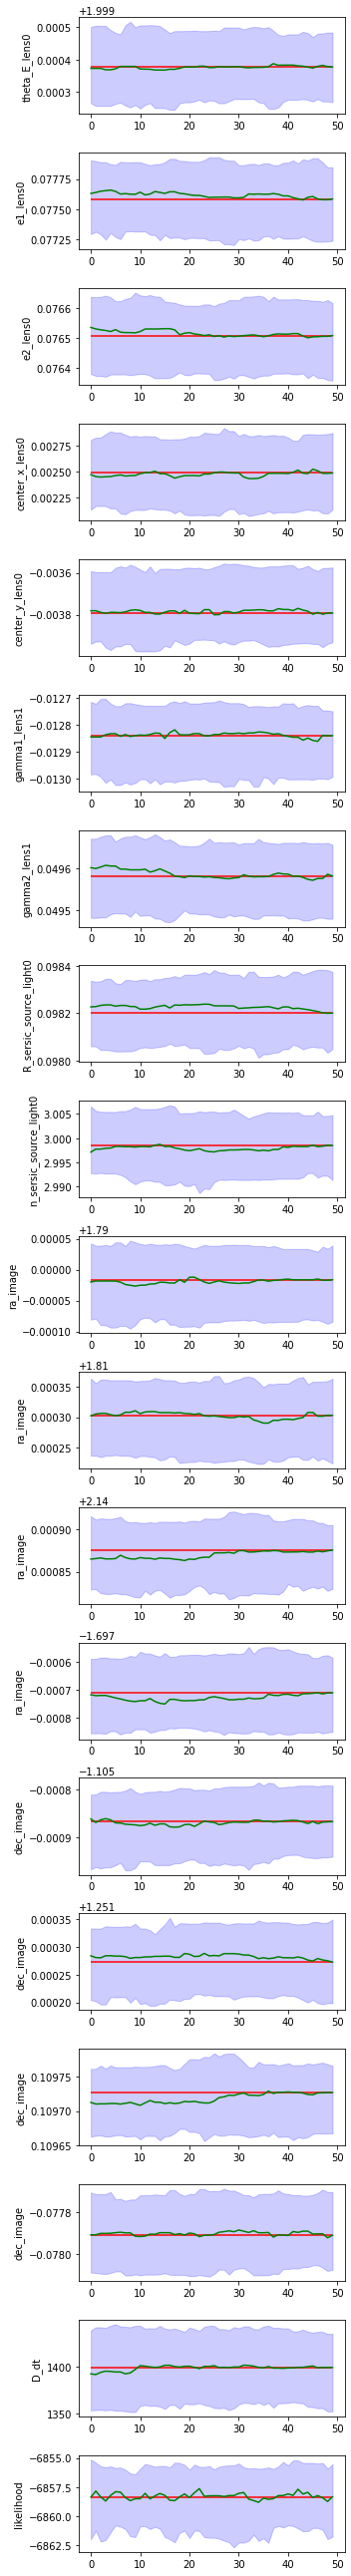

In [2]:
image_base_name = 'sie_multipole_highsnr_a4001_boxy_'
size=1
source_pos_list = ['_cusp_l']
name_out_files_ending = '_test_fit_SIE_shear'
file_name_list = []
for i in range(size):
    for source_config in source_pos_list:
        file_name_list.append(image_base_name+str(i)+source_config+'_model_sequence'+name_out_files_ending+'.npy')

        
#the path where to find the results       
path_results = os.getcwd()+'/'


ending='_mcmc_test'

wr=5
n_run_mcmc=50
n_burn_mcmc=1500
sigma=0.01


for idx,file_name in enumerate(file_name_list) :

    print("----------------")
    print(file_name)
    print("----------------")

    #---------------------
    #read result and image
    #---------------------

    [kwargs_result,chain_list,param_fit] = np.load(path_results+file_name,allow_pickle=True)


    #--------------------------------------------
    #iterate on different model for a given image
    #--------------------------------------------

    number_model=len(kwargs_result)
    for i in range(number_model):

        #----------------
        #read PSO results
        #----------------

        
        [kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params,fitting_kwargs]=param_fit[i]
        multi_band_list = kwargs_data_joint['multi_band_list']
        
        kwargs_params['lens_model'][0]=kwargs_result[i]['kwargs_lens']
        kwargs_params['source_model'][0]=kwargs_result[i]['kwargs_source']
        kwargs_params['lens_light_model'][0]=kwargs_result[i]['kwargs_lens_light']
        kwargs_params['point_source_model'][0]=kwargs_result[i]['kwargs_ps']
        kwargs_params['special'][0]=kwargs_result[i]['kwargs_special']

        #-------------------------------------------------
        #make MCMC, using the same settings as for the PSO
        #-------------------------------------------------
        
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
        fitting_kwargs_list2=[['MCMC',{'n_burn':n_burn_mcmc,'n_run':n_run_mcmc,'walkerRatio':wr,'sigma_scale':sigma}]] 
        chain_list2 = fitting_seq.fit_sequence(fitting_kwargs_list2)
        kwargs_result2 = fitting_seq.best_fit()
        chain_list[i].append(chain_list2)

        #---------------
        #plot parameters
        #---------------
        par_buf =chain_list[i][-1][0][1]
        dist_buf=chain_list[i][-1][0][3]
        num_param=len(chain_list[i][-1][0][2])
        num_chains=num_param*wr
        param_plot=np.reshape(par_buf[:,:],(n_run_mcmc,num_chains,num_param))
        dist_plot = np.reshape(dist_buf,(n_run_mcmc,num_chains))        
        percentil_values = np.percentile(param_plot,[16,50,84],axis=1)
        percentil_dist=np.percentile(dist_plot,[16,50,84],axis=1)

        f,ax=plt.subplots(nrows=num_param+1,ncols=1,figsize=(5,num_param*2))
        num_iter = np.shape(percentil_values)[1]
        x=np.arange(0,num_iter,1)
        for ip in range(num_param+1):
            if ip==num_param :
                ax[ip].fill_between(x,percentil_dist[0,:],percentil_dist[2,:],color='b',alpha=0.2)
                ax[ip].plot(x,percentil_dist[1,:],color='g')
                ax[ip].hlines(percentil_dist[1,-1],0,num_iter-1,color='r')
                ax[ip].set_ylabel('likelihood')
                continue

            ax[ip].fill_between(x,percentil_values[0,:,ip],percentil_values[2,:,ip],color='b',alpha=0.2)
            ax[ip].plot(x,percentil_values[1,:,ip],color='g')
            ax[ip].hlines(percentil_values[1,-1,ip],0,num_iter-1,color='r')
            ax[ip].set_ylabel(chain_list[i][-1][0][2][ip])
        plt.tight_layout()
        plt.savefig(path_results+file_name[:-4]+'_model'+str(i)+'_MCMC_plot.png')



    res_all=[kwargs_result,chain_list,param_fit]    

    np.save(path_results+file_name[:-4]+ending+'.npy',res_all)


## Analyze the results and plot the retrieved H0 with its associated errorbar

----------------
sie_multipole_highsnr_a4001_boxy_0_cusp_l_model_sequence_test_fit_SIE_shear_mcmc_test.npy
----------------
median H0 : 68.9
minimum chi**2 : 1.34


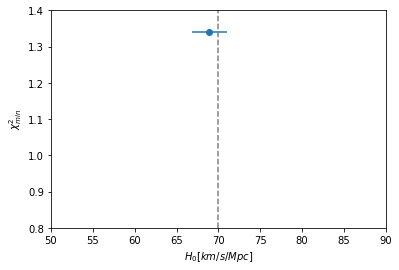

In [6]:
# Specify the fiducial cosmology
z_lens = 0.271
z_source = 2.0
H0=70
Om0=0.3
cosmo =  FlatLambdaCDM(H0=H0, Om0=Om0)


image_base_name = 'sie_multipole_highsnr_a4001_boxy_'
size=1
source_pos_list = ['_cusp_l']
name_out_files_ending = '_test_fit_SIE_shear'
ending_mcmc='_mcmc_test'
file_name_list = []
for i in range(size):
    for source_config in source_pos_list:
        file_name_list.append(image_base_name+str(i)+source_config+'_model_sequence'+name_out_files_ending+ending_mcmc+'.npy')

        
#the path where to find the results       
path_results = os.getcwd()+'/'





for num_image,file_name in enumerate(file_name_list) :
    [kwargs_result,chain_list,param_fit] = np.load(path_results+file_name,allow_pickle=True)
    number_model=len(kwargs_result)
    for model_idx in range(number_model):
        
        [kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params,fitting_kwargs]=param_fit[model_idx]
        
        if 'image_likelihood_mask_list' in kwargs_likelihood :
            [mask]=kwargs_likelihood['image_likelihood_mask_list']
        else :
            mask=np.ones_like(multi_band_list[0][0]['image_data'])

        red=np.sum(mask)
        
        par_buf =np.array(chain_list[model_idx][-1][0][1])
        param_buf_name=np.array(chain_list[model_idx][-1][0][2])
        dist_buf=np.array(chain_list[model_idx][-1][0][3])
        Ddt_low,Ddt_med,Ddt_up = np.quantile(par_buf[:,param_buf_name=='D_dt'],[0.16,0.5,0.84])
        h0_low = ddt2h0(ddt=Ddt_up, z_lens=z_lens, z_source=z_source, cosmo = cosmo)
        h0_med = ddt2h0(ddt=Ddt_med, z_lens=z_lens, z_source=z_source, cosmo = cosmo)
        h0_up = ddt2h0(ddt=Ddt_low, z_lens=z_lens, z_source=z_source, cosmo = cosmo)
        chi2_min = np.min(-dist_buf)/red *2.

        plt.errorbar(h0_med,chi2_min,xerr=[[h0_med-h0_low],[h0_up-h0_med]],marker='o')
        print("----------------")
        print(file_name)
        print("----------------")
        print('median H0 : %.1f'%h0_med)
        print('minimum chi**2 : %.2f'%chi2_min)
plt.xlim(50,90)
plt.ylim(0.8,1.4)
plt.vlines(H0,0.8,1.4,ls='--',color='grey')
plt.xlabel(r'$H_0 [km/s/Mpc]$')
plt.ylabel(r'$\chi^2_{min}$')
plt.show()